# EFFICIENTNET - B0

In [2]:
# Import libraries
from datasets import load_dataset 
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Input
import numpy as np
from PIL import Image
import os
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, GaussianNoise
from tensorflow.keras.optimizers import Adam

Using the latest cached version of the dataset since Falah/Alzheimer_MRI couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/foladeakhibi/.cache/huggingface/datasets/Falah___alzheimer_mri/default/0.0.0/daac24f9597236b45837d82f7eb9c9ad1f8c60c8 (last modified on Thu Mar 13 00:09:30 2025).


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})

Sample keys: dict_keys(['image', 'label'])
Label: 2


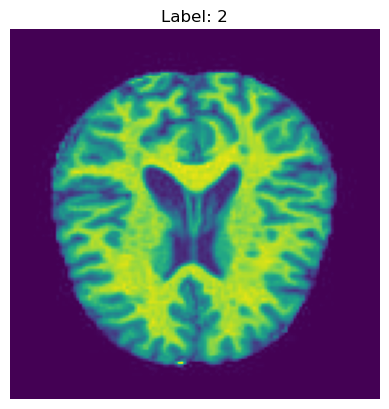

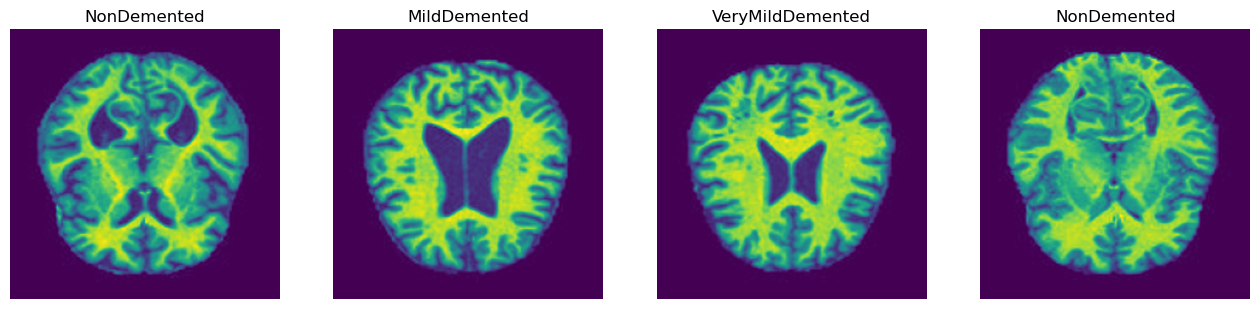

In [3]:
# Load dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

# Print dataset structure
print(dataset)

# Inspect one sample (first image and label)
sample = dataset['train'][0]
print("\nSample keys:", sample.keys())
print("Label:", sample['label'])

# Show first image
plt.imshow(sample['image'])
plt.title(f"Label: {sample['label']}")
plt.axis('off')
plt.show()


# --- Display Function that works directly from raw PIL images ---
def display_raw_samples(dataset, num_samples=4):
    label_to_class = {0: "MildDemented", 1: "ModerateDemented", 2: "NonDemented", 3: "VeryMildDemented"}
    plt.figure(figsize=(16, 4))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i, idx in enumerate(indices):
        item = dataset[int(idx)]  # Convert to plain int
        img = np.array(item['image'].resize((224, 224)))  # Resize but no normalization
        label_idx = item['label']
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(label_to_class[label_idx])
        plt.axis('off')
    plt.show()


display_raw_samples(dataset['train'], num_samples=4)

In [4]:
'''
# Create folder to store test images
output_folder = 'test_samples_v2'
os.makedirs(output_folder, exist_ok=True)  # Create if it doesn't exist

# Number of images to export (adjustable)
num_samples = 150  # You can set to as many as you like

# Class names list (adjust based on your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Loop through and save images
for i in range(num_samples):
    image = x_test[i]  # Assuming x_test is unnormalized [0-255] or scaled correctly
    label = np.argmax(y_test[i])  # Convert one-hot to class index

    # If x_test is float (0-1), scale it back to 0-255
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)

    # Convert array to PIL image
    img = Image.fromarray(image)

    # Generate filename with label for easy reference
    filename = f'{output_folder}/sample_{i}_{class_names[label]}.png'
    img.save(filename)  # Save image

    print(f"✅ Saved: {filename}")
'''

'\n# Create folder to store test images\noutput_folder = \'test_samples_v2\'\nos.makedirs(output_folder, exist_ok=True)  # Create if it doesn\'t exist\n\n# Number of images to export (adjustable)\nnum_samples = 150  # You can set to as many as you like\n\n# Class names list (adjust based on your dataset)\nclass_names = [\'MildDemented\', \'ModerateDemented\', \'NonDemented\', \'VeryMildDemented\']\n\n# Loop through and save images\nfor i in range(num_samples):\n    image = x_test[i]  # Assuming x_test is unnormalized [0-255] or scaled correctly\n    label = np.argmax(y_test[i])  # Convert one-hot to class index\n\n    # If x_test is float (0-1), scale it back to 0-255\n    if image.max() <= 1.0:\n        image = (image * 255).astype(np.uint8)\n    else:\n        image = image.astype(np.uint8)\n\n    # Convert array to PIL image\n    img = Image.fromarray(image)\n\n    # Generate filename with label for easy reference\n    filename = f\'{output_folder}/sample_{i}_{class_names[label]}.pn

In [5]:
# Parameters
image_size = (224, 224)
num_classes = 4  # there are 4 classes in total

# Preprocessing function
def preprocess_data(item):
    # Convert PIL to numpy array and then tensor
    image = np.array(item['image'].convert('RGB'))  # Ensure RGB
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, image_size)  # Resize
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize for EfficientNet
    
    label = tf.one_hot(item['label'], depth=num_classes)  # One-hot encode
    return image.numpy(), label.numpy()  # Return as NumPy for stacking later
    #return {'normalized_images': image.numpy(), 'class_labels': label.numpy()}  # Return dict
    
# Process the whole training dataset
x_list, y_list = [], []
x_test_list, y_test_list = [], []


for item in dataset['train']:
    image, label = preprocess_data(item)
    x_list.append(image)
    y_list.append(label)


for item in dataset['test']:
    image, label = preprocess_data(item)  # Use the same preprocessing function
    x_test_list.append(image)
    y_test_list.append(label)


# Convert to NumPy arrays
x_full = np.array(x_list)
y_full = np.array(y_list)

x_test = np.array(x_test_list)
y_test = np.array(y_test_list)


# Print final shapes
print(f"x_full shape: {x_full.shape}")  # Expecting (5120, 224, 224, 3)
print(f"y_full shape: {y_full.shape}")  # Expecting (5120, 4)

# Print final shapes to confirm
print(f"x_test shape: {x_test.shape}")  # Expecting (1280, 224, 224, 3)
print(f"y_test shape: {y_test.shape}")  # Expecting (1280, 4)

x_full shape: (5120, 224, 224, 3)
y_full shape: (5120, 4)
x_test shape: (1280, 224, 224, 3)
y_test shape: (1280, 4)


In [6]:
import collections

# Convert one-hot back to class indices
y_indices = np.argmax(y_full, axis=1)

# Count occurrences of each class
label_counts = collections.Counter(y_indices)

# Map numeric label to class names (optional)
label_map = {
    0: "MildDemented",
    1: "ModerateDemented",
    2: "NonDemented",
    3: "VeryMildDemented"
}

# Print 
for label_idx, count in label_counts.items():
    print(f"{label_map[label_idx]} ({label_idx}): {count} samples")

NonDemented (2): 2566 samples
MildDemented (0): 724 samples
VeryMildDemented (3): 1781 samples
ModerateDemented (1): 49 samples


In [7]:
# Load OASIS data from 'input/' directory
oasis_raw_ds = tf.keras.utils.image_dataset_from_directory(
    directory="input",
    labels="inferred",
    label_mode="categorical",  # One-hot encoding
    image_size=(224, 224),
    batch_size=1,  # Unbatched for manual splitting
    shuffle=True,
    seed=42
)

# Convert to list for manual 90/10 split
oasis_data = list(oasis_raw_ds)
total = len(oasis_data)
split_index = int(0.9 * total)

oasis_train_data = oasis_data[:split_index]
oasis_val_data = oasis_data[split_index:]

# Helper to unpack into tensors
def unpack(samples):
    images = [tf.squeeze(img, axis=0) for img, _ in samples]
    labels = [tf.squeeze(lbl, axis=0) for _, lbl in samples]
    return tf.stack(images), tf.stack(labels)

# Unpack datasets
x_oasis_train, y_oasis_train = unpack(oasis_train_data)
x_oasis_val, y_oasis_val = unpack(oasis_val_data)

# Confirm shapes
print("✅ OASIS Train:", x_oasis_train.shape, y_oasis_train.shape)
print("✅ OASIS Val:", x_oasis_val.shape, y_oasis_val.shape)

# Check one-hot label distributions
oasis_train_labels = np.argmax(y_oasis_train.numpy(), axis=1)
oasis_val_labels = np.argmax(y_oasis_val.numpy(), axis=1)

from collections import Counter
print("🧾 OASIS Train Class Distribution:", Counter(oasis_train_labels))
print("🧾 OASIS Val Class Distribution:", Counter(oasis_val_labels))

Found 2938 files belonging to 4 classes.


2025-04-20 13:43:38.658146: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✅ OASIS Train: (2644, 224, 224, 3) (2644, 4)
✅ OASIS Val: (294, 224, 224, 3) (294, 4)
🧾 OASIS Train Class Distribution: Counter({0: 1450, 3: 627, 1: 432, 2: 135})
🧾 OASIS Val Class Distribution: Counter({0: 150, 3: 73, 1: 56, 2: 15})


In [8]:
# Train/Validation split (80/20)
x_train, x_val, y_train, y_val = train_test_split(
    x_full, y_full, test_size=0.2, random_state=42, shuffle=True
)

# Print shapes to confirm
print(f"x_train shape: {x_train.shape}")  # (4096, 224, 224, 3)
print(f"y_train shape: {y_train.shape}")  # (4096, 4)
print(f"x_val shape: {x_val.shape}")      # (1024, 224, 224, 3)
print(f"y_val shape: {y_val.shape}")      # (1024, 4)

# Total samples check
print(f"Total train samples: {len(x_train)}") 
print(f"Total val samples: {len(x_val)}")

x_train shape: (4096, 224, 224, 3)
y_train shape: (4096, 4)
x_val shape: (1024, 224, 224, 3)
y_val shape: (1024, 4)
Total train samples: 4096
Total val samples: 1024


In [9]:
# --- Combine Hugging Face + OASIS ---
# Train set
x_combined_train = np.concatenate([x_train, x_oasis_train], axis=0)
y_combined_train = np.concatenate([y_train, y_oasis_train], axis=0)

# Val set
x_combined_val = np.concatenate([x_val, x_oasis_val], axis=0)
y_combined_val = np.concatenate([y_val, y_oasis_val], axis=0)

# Confirm shapes
print(f"✅ Combined Train: {x_combined_train.shape}, {y_combined_train.shape}")
print(f"✅ Combined Val: {x_combined_val.shape}, {y_combined_val.shape}")

✅ Combined Train: (6740, 224, 224, 3), (6740, 4)
✅ Combined Val: (1318, 224, 224, 3), (1318, 4)


In [10]:
# Convert one-hot labels to class indices
train_labels_index = np.argmax(y_combined_train, axis=1)
val_labels_index = np.argmax(y_combined_val, axis=1)

# Class distribution
from collections import Counter
train_distribution = Counter(train_labels_index)
val_distribution = Counter(val_labels_index)

print("📦 Train Class Distribution:", train_distribution)
print("📦 Val Class Distribution:", val_distribution)

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels_index),
    y=train_labels_index
)
#class_weights_dict = {i: min(w, 2.5) for i, w in enumerate(class_weights)}  # optional cap at 2.0
class_weights_dict = dict(enumerate(class_weights))   # no min()

print("🧮 Adjusted Class Weights:", class_weights_dict)

📦 Train Class Distribution: Counter({2: 2168, 3: 2058, 0: 2038, 1: 476})
📦 Val Class Distribution: Counter({2: 548, 3: 423, 0: 286, 1: 61})
🧮 Adjusted Class Weights: {0: 0.8267909715407262, 1: 3.5399159663865545, 2: 0.7772140221402214, 3: 0.8187560738581147}


In [11]:

# Define the input
input_tensor = Input(shape=(224, 224, 3))

# Apply GaussianNoise only during training
x = GaussianNoise(0.01)(input_tensor, training=True)  # <- this ensures it's applied only during training

# Load EfficientNetB0 base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)

# Freeze first N layers (adjust as needed)
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Extract multi-scale features
x1 = base_model.get_layer('block2a_activation').output
x2 = base_model.get_layer('block4a_activation').output
x3 = base_model.get_layer('top_activation').output

# Global Average Pooling
x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)
x3 = GlobalAveragePooling2D()(x3)

# Concatenate all pooled features
x = Concatenate()([x1, x2, x3])
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

# Final model
multi_scale_model = Model(inputs=input_tensor, outputs=output)

# Compile model
multi_scale_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = multi_scale_model.fit(
    x_combined_train,
    y_combined_train,
    validation_data=(x_combined_val, y_combined_val),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict
)

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 173s 785ms/step - accuracy: 0.4674 - loss: 1.2984 - val_accuracy: 0.6859 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 174s 825ms/step - accuracy: 0.7531 - loss: 0.4815 - val_accuracy: 0.7830 - val_loss: 0.4944 - learning_rate: 1.0000e-04
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 176s 832ms/step - accuracy: 0.8421 - loss: 0.3271 - val_accuracy: 0.7830 - val_loss: 0.5029 - learning_rate: 1.0000e-04
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 193s 912ms/step - accuracy: 0.8901 - loss: 0.2276 - val_accuracy: 0.8801 - val_loss: 0.3214 - learning_rate: 1.0000e-04
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 205s 972ms/step - accuracy: 0.9361 - loss: 0.1445 - val_accuracy: 0.9219 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9547 - loss: 0.1069 - val_accuracy: 0.9226 - val_loss: 0.2064 - learning_rate: 1.0000e-04
Epoch 7/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 223

In [12]:
# Evaluate on the test set
test_loss, test_accuracy = multi_scale_model.evaluate(x_test, y_test, batch_size=32, verbose=1)

# Print test performance
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 654ms/step - accuracy: 0.9558 - loss: 0.1998
✅ Test Accuracy: 96.17%
✅ Test Loss: 0.1638


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Convert predictions and true labels to class indices
y_pred_probs = multi_scale_model.predict(x_test, batch_size=32)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("📋 Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]))

# Confusion matrix|
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 645ms/step
📋 Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.98      0.93      0.96       172
ModerateDemented       1.00      0.93      0.97        15
     NonDemented       0.96      0.98      0.97       634
VeryMildDemented       0.95      0.95      0.95       459

        accuracy                           0.96      1280
       macro avg       0.97      0.95      0.96      1280
    weighted avg       0.96      0.96      0.96      1280



array([[160,   0,   3,   9],
       [  0,  14,   0,   1],
       [  1,   0, 621,  12],
       [  2,   0,  21, 436]])

<Figure size 800x600 with 0 Axes>

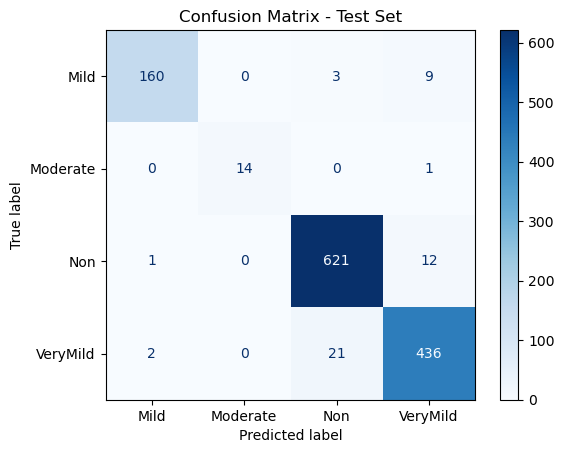

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mild", "Moderate", "Non", "VeryMild"])

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

In [15]:
'''
# Save entire model
multi_scale_model.save('EN_B0v9999.keras')
print("Model saved successfully!")
'''

'\n# Save entire model\nmulti_scale_model.save(\'EN_B0v9999.keras\')\nprint("Model saved successfully!")\n'

In [16]:
multi_scale_model.summary(line_length=120)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 224, 224, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ gaussian_noise (GaussianNoise)    │ (None, 224, 224, 3)          │                 0 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ rescaling (Rescaling)             │ (None, 224, 224, 3)          │                 0 │ gaussian_noise[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ normalization (Normalization)     │ (None, 224, 224, 3)          │                 7 │ rescaling[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ rescaling_1 (Rescaling)           │ (None, 224, 224, 3)          │                 0 │ normalization[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_conv_pad (ZeroPadding2D)     │ (None, 225, 225, 3)          │                 0 │ rescaling_1[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_conv (Conv2D)                │ (None, 112, 112, 32)         │               864 │ stem_conv_pad[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_bn (BatchNormalization)      │ (None, 112, 112, 32)         │               128 │ stem_conv[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_activation (Activation)      │ (None, 112, 112, 32)         │                 0 │ stem_bn[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_dwconv (DepthwiseConv2D)  │ (None, 112, 112, 32)         │               288 │ stem_activation[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_bn (BatchNormalization)   │ (None, 112, 112, 32)         │               128 │ block1a_dwconv[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_activation (Activation)   │ (None, 112, 112, 32)         │                 0 │ block1a_bn[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_se_squeeze                │ (None, 32)                   │                 0 │ block1a_activation[0][0]  
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_se_reshape (Reshape)      │ (None, 1, 1, 32)             │                 0 │ block1a_se_squeeze[0][0]  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_se_reduce (Conv2D)        │ (None, 1, 1, 8)              │               264 │ block1a_se_reshape[0][0]  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ block1a_se_expand (Conv2D)        │ (None, 1, 1, 32)  

 Total params: 12,250,777 (46.73 MB)

 Trainable params: 3,893,112 (14.85 MB)

 Non-trainable params: 571,439 (2.18 MB)

 Optimizer params: 7,786,226 (29.70 MB)

# IMPLEMENTING PRINCIPAL COMPONENT ANALYSIS (PCA)

In [18]:
import tensorflow as tf, numpy as np

EN_B0 = tf.keras.models.load_model('EN_B0v9999.keras')
_ = EN_B0(tf.zeros((1, 224, 224, 3)))   # builds graph

print("✅ Model loaded. Output layer =", EN_B0.layers[-1].name)

✅ Model loaded. Output layer = dense_5


In [19]:
# grab the Dropout output (layer -2)
dropout_output = EN_B0.layers[-2].output
print("dropout_output shape:", dropout_output.shape)      # should be (None, 256)

feature_extractor = tf.keras.Model(
        inputs=EN_B0.input,
        outputs=dropout_output)

print("✅ feature_extractor ready.")

dropout_output shape: (None, 256)
✅ feature_extractor ready.


In [20]:
# Assuming your test set is x_test and y_test
x_arr = x_test.copy()
y_arr = y_test.copy()

print("x_arr:", x_arr.shape, x_arr.dtype)
print("y_arr:", y_arr.shape, y_arr.dtype)

x_arr: (1280, 224, 224, 3) float32
y_arr: (1280, 4) float32


In [21]:
BATCH = 64

# Create batched dataset
test_feat_ds = tf.data.Dataset.from_tensor_slices(x_arr).batch(BATCH)

# Extract features
feature_list = []
for xb in test_feat_ds:
    z = feature_extractor(xb, training=False)   # output shape: (batch, 256)
    feature_list.append(z)

features = tf.concat(feature_list, axis=0).numpy()
print("✅ features:", features.shape)

✅ features: (1280, 256)


2025-04-20 15:29:46.485414: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components for 2D visualization
pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(features)

print("✅ PCA complete →", x_test_pca.shape)

✅ PCA complete → (1280, 2)


# SCATTER PLOTS AND GRAPHS

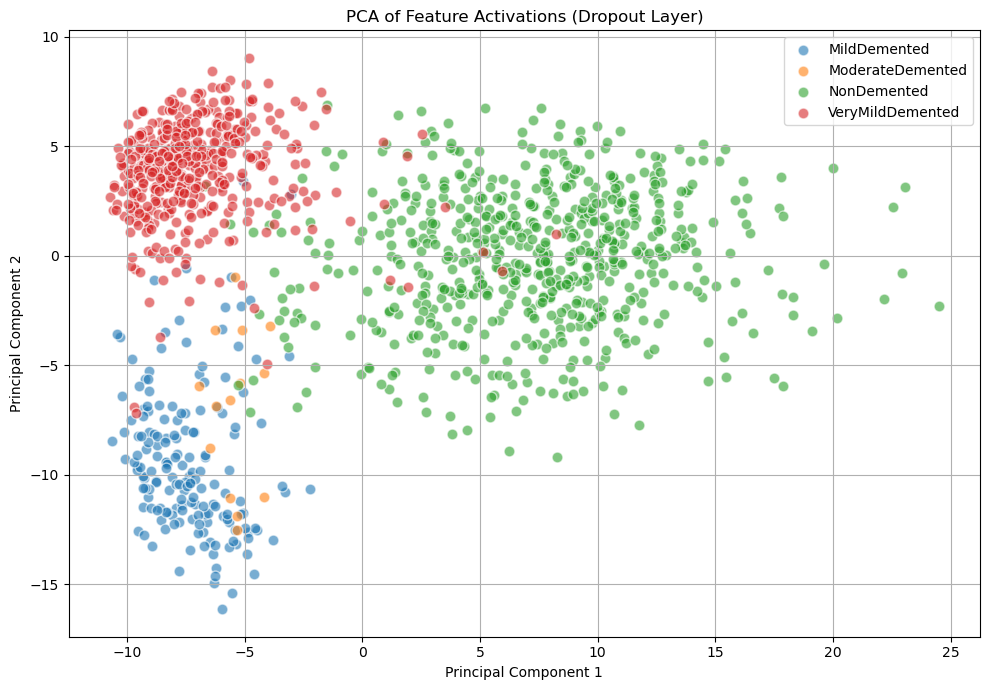

In [24]:
import matplotlib.pyplot as plt

# These are your original labels — convert to class indices
y_test_indices = np.argmax(y_arr, axis=1)

# Label map (adjust if your label ordering is different)
label_names = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

plt.figure(figsize=(10, 7))

# Plot each class with its own color
for class_index in np.unique(y_test_indices):
    idx = np.where(y_test_indices == class_index)
    plt.scatter(
        x_test_pca[idx, 0],
        x_test_pca[idx, 1],
        label=label_names[class_index],
        alpha=0.6,
        edgecolors='w',
        s=60
    )

plt.title("PCA of Feature Activations (Dropout Layer)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

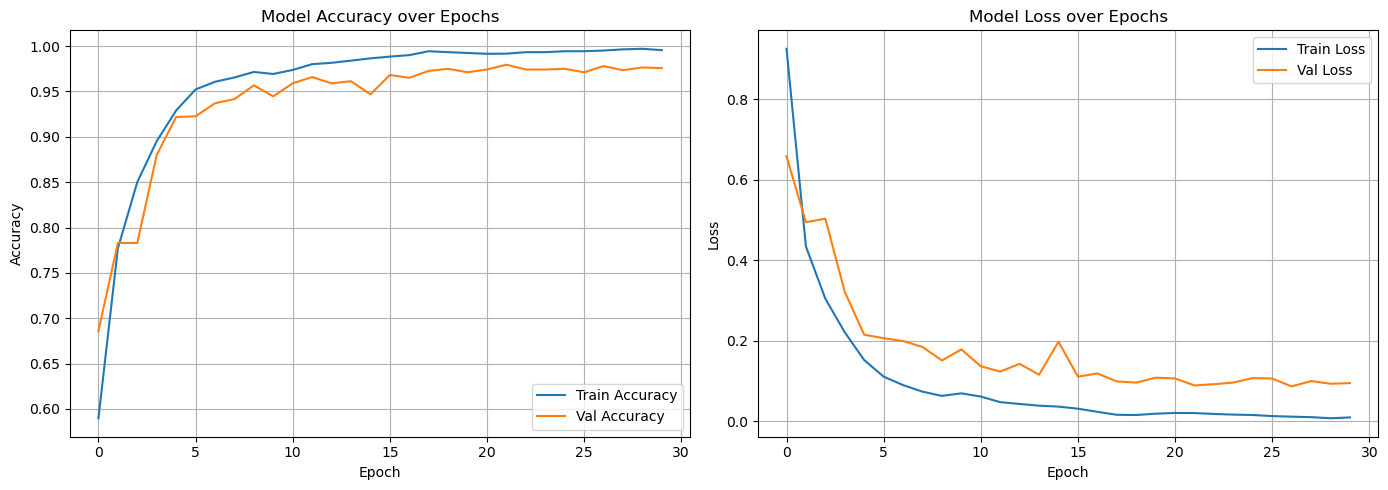

In [25]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Predict class probabilities for all test samples
y_pred_probs = EN_B0.predict(x_arr, batch_size=64, verbose=1)

print("✅ Predictions ready:", y_pred_probs.shape)  # Should be (1280, 4)

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
✅ Predictions ready: (1280, 4)


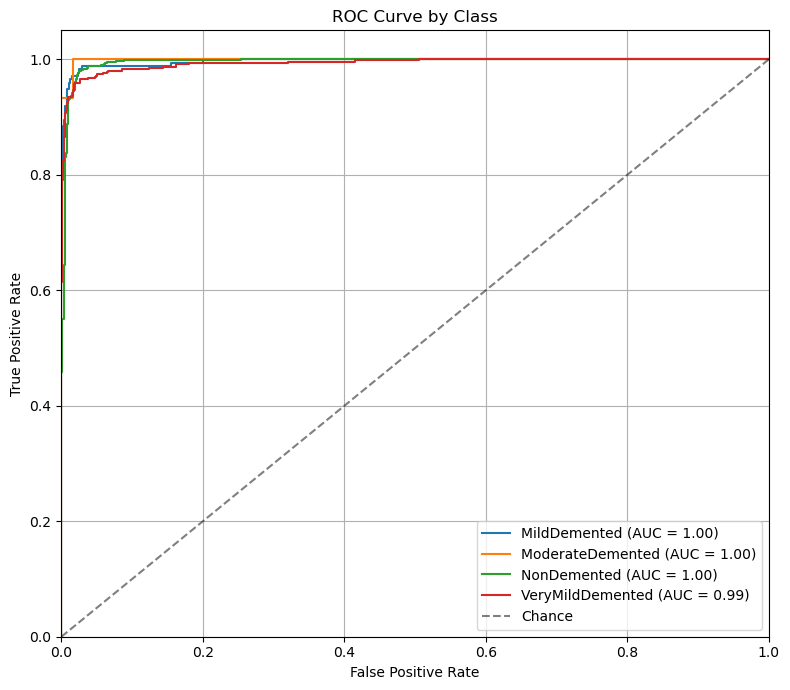

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize ground truth labels if not already
y_true_bin = y_arr  # Already one-hot from your setup
n_classes = y_true_bin.shape[1]
class_names = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

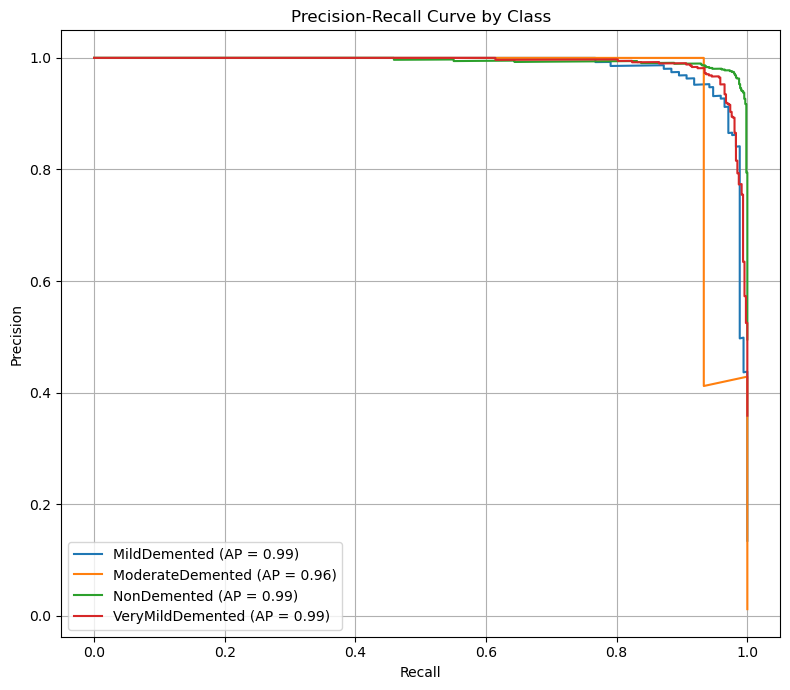

In [63]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall and average precision for each class
precision = {}
recall = {}
avg_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 7))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"{class_names[i]} (AP = {avg_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve by Class")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()